In [1]:
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
import re
import os
from dotenv import load_dotenv
load_dotenv()
from typing_extensions import TypedDict,Annotated
import operator
from langgraph.graph import StateGraph,START,END


In [2]:
model=ChatOpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=os.getenv("OPENROUTER_DEEPSEEK_API_KEY"),  # or hardcode for now
            model="deepseek/deepseek-chat",
            temperature=0.7,
            max_tokens=500
        )

# response = model.invoke(full_prompt)

In [3]:
class EvaluationSchema(BaseModel):
    feedback:str = Field(..., description="Feedback for the essay")
    score:float = Field(..., description="Score for the essay out of 10")
    
structured_model=model.with_structured_output(EvaluationSchema)

In [4]:
essay="India is a democracy. That mean=s people can vote for their leaders. There are many political parties, like BJP, Congress, and others. People vote every few years in elections.The Indian polity also gives people rights, like freedom of speech and equality."

In [5]:
load_dotenv()
# essay=os.getenv("text")
prompt=f"Provide concise feedback on the language of following essay and rate it out of 10 \n\n {essay} "
print(prompt)

Provide concise feedback on the language of following essay and rate it out of 10 

 India is a democracy. That mean=s people can vote for their leaders. There are many political parties, like BJP, Congress, and others. People vote every few years in elections.The Indian polity also gives people rights, like freedom of speech and equality. 


In [6]:
structured_model.invoke(prompt)

EvaluationSchema(feedback="The essay conveys basic ideas about India's democracy and political system but suffers from several language issues. Here’s a breakdown:\n1. **Grammar**: 'mean=s' is a typo and should be 'means.'\n2. **Clarity**: The essay is overly simplistic and lacks depth. For example, it could elaborate on how democracy functions or the significance of rights like freedom of speech.\n3. **Structure**: The sentences are short and choppy, making the essay feel disjointed. Better transitions and more complex sentence structures would improve readability.\n4. **Vocabulary**: The language is very basic and repetitive (e.g., 'People vote every few years in elections' could be rephrased for variety).\n5. **Content**: The essay touches on key points but does not explore them in any meaningful way. Adding examples or details would strengthen the argument.\n6. **Overall**: The essay is functional but lacks sophistication and depth.", score=4.0)

In [7]:
class State_holder(TypedDict):
    essay:str
    lang_feedback:str
    eff_feedback:str
    fun_feedback:str
    individual_scores:Annotated[list[float], operator.add]
    final_score:float
    rvw:str
# operator is the reducer-- max, multiplication and a loads of such operator are available
    
    


In [8]:
def evaluate_lang(state: State_holder):
    prompt = f"Provide concise feedback on the language of following essay and rate it out of 10 \n\n {state['essay']} "
    response=structured_model.invoke(prompt)
    # state.lang_feedback = response.feedback
    return {'lang_feedback':response.feedback,'individual_scores':[response.score]}

def evaluate_fun(state: State_holder):
    prompt = f"Provide concise feedback on the humor of following essay and rate it out of 10 \n\n {state['essay']} "
    response=structured_model.invoke(prompt)
    # state.lang_feedback = response.feedback
    return {'fun_feedback':response.feedback,'individual_scores':[response.score]}

def evaluate_eff(state: State_holder):
    prompt = f"Provide concise feedback on the effectivity of following essay and rate it out of 10 \n\n {state['essay']} "
    response=structured_model.invoke(prompt)
    # state.lang_feedback = response.feedback
    return {'eff_feedback':response.feedback,'individual_scores':[response.score]}

def final_evaluation(state: State_holder):
    prompt=f"add following feedbacks to generate one final feedback for the essay \n\n Language Feedback: {state['lang_feedback']} \n\n Humor Feedback: {state['fun_feedback']} \n\n Effectivity Feedback: {state['eff_feedback']} \n\n Essay: {state['essay']}"
    response=model.invoke(prompt)
    final_score = sum(state['individual_scores']) / len(state['individual_scores'])
    state['final_score'] = final_score
    state['rvw'] = response
    return state


In [10]:
graph=StateGraph(State_holder)

graph.add_node('evalaute_language',evaluate_lang)
graph.add_node('evalaute_fun',evaluate_fun)
graph.add_node('evalaute_effectivity',evaluate_eff)

graph.add_node('final_evaluation',final_evaluation)

In [11]:
graph.add_edge(START, 'evalaute_language')
graph.add_edge(START, 'evalaute_fun')
graph.add_edge(START, 'evalaute_effectivity')
graph.add_edge('evalaute_language', 'final_evaluation')
graph.add_edge('evalaute_fun', 'final_evaluation')
graph.add_edge('evalaute_effectivity', 'final_evaluation')
graph.add_edge('final_evaluation', END)


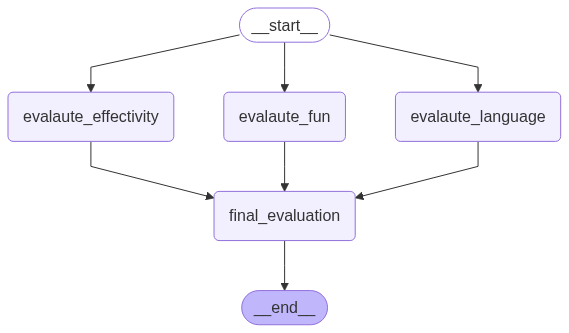

In [12]:
workflow = graph.compile()
workflow

In [13]:
# class State_holder(TypedDict):
#     essay:str
#     lang_feedback:str
#     eff_feedback:str
#     fun_feedback:str
#     individual_scores:Annotated[list[float], operator.add]
#     final_score:float
#     rvw:str
    
initial_state={"essay":essay}

workflow.invoke(initial_state)

{'essay': 'India is a democracy. That mean=s people can vote for their leaders. There are many political parties, like BJP, Congress, and others. People vote every few years in elections.The Indian polity also gives people rights, like freedom of speech and equality.',
 'lang_feedback': "The essay is clear and conveys basic information about India's democracy, but it has several language issues. 'That mean=s' is a typo and should be 'That means.' The sentences are simple and repetitive, lacking variety in structure. The essay could benefit from more specific examples or elaboration on rights like freedom of speech and equality. Overall, the language is functional but lacks sophistication and depth.",
 'eff_feedback': "This essay is concise and provides a basic overview of India's democratic system, but it lacks depth, clarity, and structure. The sentence 'That mean=s people can vote for their leaders' contains a typographical error ('mean=s'), which impacts readability. The essay menti